# Imports

In [2]:
import os
import sys
sys.path.append(os.path.realpath(".."))

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from evlp_bronch.dataset import ALL_LUNG_IDS, ProcessedEVLPDataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import tqdm as tqdm

# Device Setup

In [3]:
device = torch.device("mps")

# Load Data

In [4]:
train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=0
)
train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=0
)
# Splits result should be deterministic
assert set(val_lung_ids) == {38, 26}, str(val_lung_ids)
assert set(test_lung_ids) == {27, 36}, str(test_lung_ids)

train_dataset = ProcessedEVLPDataset(train_lung_ids)
val_dataset = ProcessedEVLPDataset(val_lung_ids)
test_dataset = ProcessedEVLPDataset(test_lung_ids)

In [5]:
len(train_dataset), len(val_dataset), len(test_dataset)

(214, 4, 7)

# Data Visualization

In [6]:
for i in range(len(train_dataset)):
    if train_dataset[i]['Lung_id'] == 6:
        tmp = train_dataset[i+2]
        break

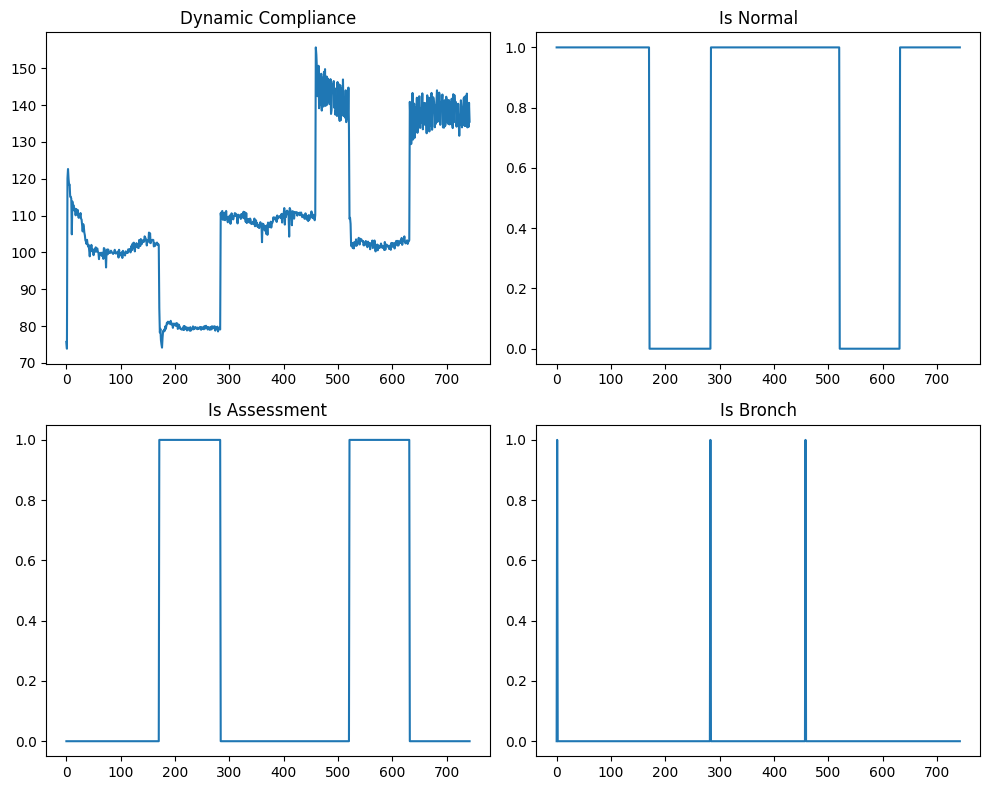

In [7]:
a = test_dataset[2]['Dy_comp']
c = test_dataset[2]['Is_normal']
b = test_dataset[2]['Is_assessment']
d = test_dataset[2]['Is_bronch']

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Dynamic Compliance')
plt.plot(a)

plt.subplot(2, 2, 2)
plt.title('Is Normal')
plt.plot(c)

plt.subplot(2, 2, 3)
plt.title('Is Assessment')
plt.plot(b)

plt.subplot(2, 2, 4)
plt.title('Is Bronch')
plt.plot(d)

plt.tight_layout()

# Utils Functions

In [8]:
def rindex(lst, value): # find the last occurence of a value in a list
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1

In [9]:
# def center_pad_sequence(sequence, target_length): # centre pad with same value
#         current_length = len(sequence)
#         total_padding = target_length - current_length
#         if total_padding <= 0:
#             return sequence

#         pad_before = total_padding // 2
#         pad_after = total_padding - pad_before

#         return np.pad(sequence, (pad_before, pad_after), mode='edge')
# len(center_pad_sequence(train_dataset[0]['Is_bronch'][:1+1], 1470))

1470

In [10]:
def right_pad_sequence(sequence, target_length):
    current_length = len(sequence)
    total_padding = target_length - current_length
    if total_padding <= 0:
        return sequence
    pad_after = total_padding

    return np.pad(sequence, (0, pad_after), mode='edge')
len(right_pad_sequence(train_dataset[0]['Dy_comp'][:1+1], 1470))
train_dataset[0]['Dy_comp'][:1+1]


array([79.11244541, 81.05219547])

# Set dataset

In [11]:
X_dc = []
X_is_normal = []
X_is_bronch = []
X_is_assess = []

Y = []
Y_len = []

for i in train_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins

    # Find the first assessment period that starts after the last bronch occurrence
    first_assessment_after_bronch = None
    for change in changes:
        if change > metric_start + 5:
            first_assessment_after_bronch = change
            break

    if metric_start + 5 < (len(i['Is_assessment']) - 1) * 0:
        continue

    if first_assessment_after_bronch is None:
        first_assessment_after_bronch = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal.append(right_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_assess.append(right_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_bronch.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y_len.append(len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch])) # 记录长度，用于计算loss)
    Y.append(right_pad_sequence(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch], 1054))

print(f"length is {len(X_dc)}")    
assert len(X_dc) == len(X_is_assess) == len(X_is_bronch) == len(X_is_normal) == len(Y), "Inconsistent number of samples"

X_dc = np.array(X_dc).reshape(-1, 1470)
X_is_normal = np.array(X_is_normal).reshape(-1, 1470)
X_is_bronch = np.array(X_is_bronch).reshape(-1, 1470)
X_is_assess = np.array(X_is_assess).reshape(-1, 1470)
Y = torch.from_numpy(np.array(Y)).float()
Y_len = torch.from_numpy(np.array(Y_len)).int()

length is 165


In [12]:
X_dc_val = []
X_is_normal_val = []
X_is_bronch_val = []
X_is_assess_val = []

Y_val = []
Y_val_len = []

for i in val_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins

    # Find the first assessment period that starts after the last bronch occurrence
    first_assessment_after_bronch = None
    for change in changes:
        if change > metric_start + 5:
            first_assessment_after_bronch = change
            break

    if metric_start < (len(i['Is_assessment']) - 1) * 0:
        continue

    if first_assessment_after_bronch is None:
        first_assessment_after_bronch = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc_val.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal_val.append(right_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_bronch_val.append(right_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_assess_val.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y_val_len.append(len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch])) # 记录每个样本的长度，用于后面的pad操作
    Y_val.append(right_pad_sequence(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch], 1054))

print(f"length is {len(X_dc_val)}") 
assert len(X_dc_val) == len(X_is_normal_val) == len(X_is_bronch_val) == len(X_is_assess_val) == len(Y_val), "Inconsistent number of samples" 

X_dc_val = np.array(X_dc_val).reshape(-1, 1470)
X_is_normal_val = np.array(X_is_normal_val).reshape(-1, 1470)
X_is_bronch_val = np.array(X_is_bronch_val).reshape(-1, 1470)
X_is_assess_val = np.array(X_is_assess_val).reshape(-1, 1470)
Y_val = torch.from_numpy(np.array(Y_val)).float()
Y_val_len = torch.from_numpy(np.array(Y_val_len)).int()

length is 4


In [13]:
X_dc_test = []
X_is_normal_test = []
X_is_bronch_test = []
X_is_assess_test = []

Y_test = []
Y_test_len = []

for i in test_dataset:
    metric_start = rindex(list(i['Is_bronch']), 1) # find the last bronch
    changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins

    # Find the first assessment period that starts after the last bronch occurrence
    first_assessment_after_bronch = None
    for change in changes:
        if change > metric_start + 5:
            first_assessment_after_bronch = change
            break

    if metric_start < (len(i['Is_assessment']) - 1) * 0:
        continue

    if first_assessment_after_bronch is None:
        first_assessment_after_bronch = len(i['Is_assessment']) - 1
    if len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
        continue

    # 做padding，保证长度一致，用最长的长度
    X_dc_test.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], 1470))
    X_is_normal_test.append(right_pad_sequence(i['Is_normal'][:metric_start+1], 1470))
    X_is_bronch_test.append(right_pad_sequence(i['Is_assessment'][:metric_start+1],1470))
    X_is_assess_test.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], 1470))

    Y_test_len.append(len(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch])) # 记录每个sample的长度，用于后面的pad操作
    Y_test.append(right_pad_sequence(i['Dy_comp'][metric_start + 5:first_assessment_after_bronch], 1054))

print(f"length is {len(X_dc_test)}") 
assert len(X_dc_test) == len(X_is_normal_test) == len(X_is_bronch_test) == len(X_is_assess_test) == len(Y_test), "Inconsistent number of samples" 
X_dc_test = np.array(X_dc_test).reshape(-1, 1470)
X_is_normal_test = np.array(X_is_normal_test).reshape(-1, 1470)
X_is_bronch_test = np.array(X_is_bronch_test).reshape(-1, 1470)
X_is_assess_test = np.array(X_is_assess_test).reshape(-1, 1470)
Y_test = torch.from_numpy(np.array(Y_test)).float()
Y_test_len = torch.from_numpy(np.array(Y_test_len)).int()


length is 7


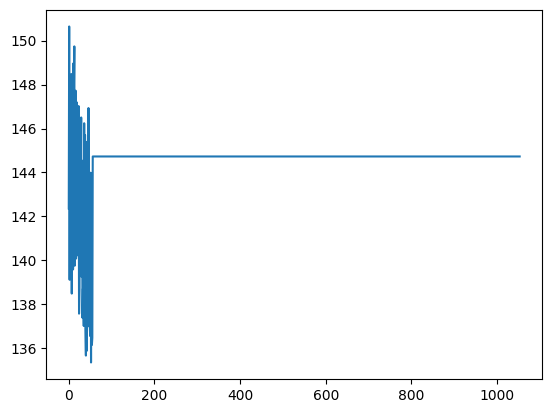

In [14]:
plt.plot(Y_test[2])

## Don't do this if not PyTorch

In [15]:
X_combined = np.stack([X_dc, X_is_normal, X_is_assess, X_is_bronch], axis=1)  # Shape becomes [N, 4, 1470]
X_combined = torch.from_numpy(X_combined).float()

X_combined_val = np.stack([X_dc_val, X_is_normal_val, X_is_assess_val, X_is_bronch_val], axis=1) 
X_combined_val = torch.from_numpy(X_combined_val).float()

X_combined_test = np.stack([X_dc_test, X_is_normal_test, X_is_assess_test, X_is_bronch_test], axis=1) 
X_combined_test = torch.from_numpy(X_combined_test).float()

# PyTorch

In [17]:
class EVLPDataset(Dataset):
    def __init__(self, X_combined, Y, Y_len):
        self.X_combined = X_combined
        self.Y = Y
        self.Y_len = Y_len

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X_combined[idx], self.Y[idx], self.Y_len[idx]
    
train_loader = DataLoader(EVLPDataset(X_combined, Y, Y_len), batch_size=32, shuffle=True)
val_loader = DataLoader(EVLPDataset(X_combined_val, Y_val, Y_val_len), batch_size=1, shuffle=False)
test_loader = DataLoader(EVLPDataset(X_combined_test, Y_test, Y_test_len), batch_size=1, shuffle=False)

In [159]:
def train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    epoch_losses = []  # List to store average training loss per epoch
    val_losses = []    # List to store average validation loss per epoch

    val_target = []
    val_predict = []
    
    for epoch in range(epochs):

        # training
        running_loss = 0.0

        for inputs, y, _ in train_loader:
            inputs, y = inputs.to(device), y[:,0].to(device)
            optimizer.zero_grad()

            # output.shape = [batch_size]
            outputs = model(inputs).squeeze()
            
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        average_loss = running_loss / len(train_loader)
        epoch_losses.append(average_loss)

        # validation
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for inputs, y, _ in val_loader:
                inputs, y = inputs.to(device), y[:, 0].to(device)
                outputs = model(inputs).squeeze()

                loss = criterion(outputs, y)
                val_loss = criterion(outputs, y)
   
                if epoch == epochs - 1:
                    val_predict.append(outputs)
                    val_target.append(y)
    
                running_val_loss += val_loss.item()

            average_val_loss = running_val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Training Loss: {average_loss}, Validation Loss: {average_val_loss}")

        model.train()

    # Plotting

    # scatter plot
    index = [i for i in range(len(val_predict))]
    pred = np.array([tensor.item() for tensor in val_predict])
    actual = np.array([tensor.item() for tensor in val_target])

    plt.figure(figsize=(7, 4))
    plt.scatter(index, actual, label='Actual')
    plt.scatter(index, pred, label='Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

    # training & validation loss
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o', color='blue', label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, marker='o', color='red', label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    model.eval()

    # testing
    # output_ls = []
    # target_ls = []

    test_loss = 0
    with torch.no_grad():
        for data, y, _ in test_loader:
            data, y = data.to(device), y[:, 0].to(device)
            outputs = model(data).squeeze()

            loss = criterion(outputs, y)

            # output_ls.append(pred_medians)
            # target_ls.append(target_medians)

            test_loss += loss.item()

    test_loss /= len(test_loader.dataset)

    # scatter plot
    index = [i for i in range(len(y))]
    pred = outputs.tolist()
    actual = y.tolist()

    plt.figure(figsize=(7, 4))
    plt.scatter(0, actual, label='Actual')
    plt.scatter(0, pred, label='Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

    print(f'Test set: Average loss: {test_loss:.4f}')

In [207]:
class DNN(nn.Module):
    def __init__(self, num_filters=64, num_in_channels=4):
        super(DNN, self).__init__()

        self.linear1 = nn.Linear(num_in_channels * 1470, num_filters)
        self.linear2 = nn.Linear(num_filters, 128)
        self.linear3 = nn.Linear(128, 256)
        self.final_layer = nn.Linear(in_features=256, out_features=1)

        nn.init.uniform_(self.linear1.weight, a=0.001, b=0.01)
        nn.init.uniform_(self.linear2.weight, a=0.001, b=0.01)
        nn.init.uniform_(self.linear3.weight, a=0.001, b=0.01)
        nn.init.uniform_(self.final_layer.weight, a=0.001, b=0.01)

        self.conv_seq = nn.Sequential(
            self.linear1,
            nn.ReLU(),
            self.linear2,
            nn.ReLU(),
            self.linear3,
            nn.ReLU(),
            self.final_layer)

        

    def forward(self, x):
        # Reshape the input tensor to [batch_size, num_in_channels * 1470]
        x = x.view(x.size(0), -1)

        x = self.conv_seq(x)
        return x

Epoch 10, Training Loss: 1200.2764358520508, Validation Loss: 352.67782855033875
Epoch 20, Training Loss: 1230.4845530192058, Validation Loss: 138.66494804620743
Epoch 30, Training Loss: 1253.5777842203777, Validation Loss: 115.45594024658203
Epoch 40, Training Loss: 1117.8871103922527, Validation Loss: 148.30665490031242
Epoch 50, Training Loss: 1181.9622192382812, Validation Loss: 179.95892429351807
Epoch 60, Training Loss: 1069.7758617401123, Validation Loss: 118.67756283283234
Epoch 70, Training Loss: 1083.769322713216, Validation Loss: 132.2071236371994
Epoch 80, Training Loss: 1311.7988739013672, Validation Loss: 151.8079583644867
Epoch 90, Training Loss: 1026.2205200195312, Validation Loss: 209.20146942138672
Epoch 100, Training Loss: 1007.5596783955892, Validation Loss: 196.91865611076355


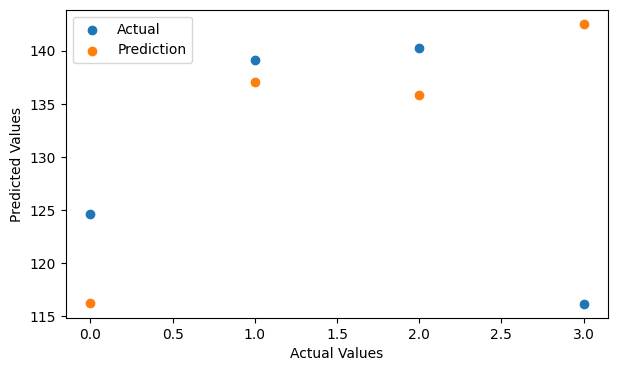

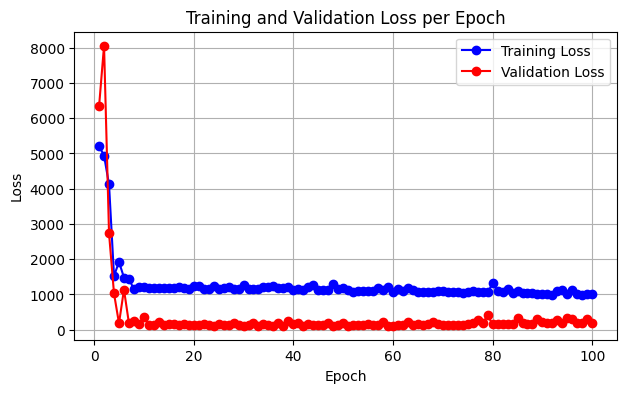

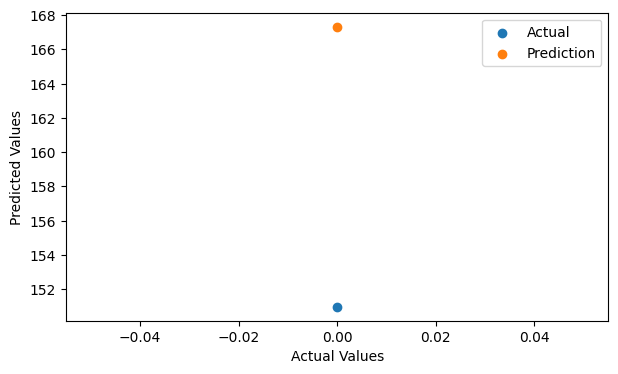

Test set: Average loss: 143.3257


In [213]:
epochs = 100
model = DNN(num_filters=64, num_in_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, amsgrad=True, weight_decay=0.00001)
criterion = nn.MSELoss()

train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)